# DATA LODING

In [10]:
pip install numpy pandas matplotlib seaborn opencv-python scikit-learn tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
# Core Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
import random
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('ggplot')

In [12]:
# Files already renamed in previous run - skipping to avoid FileExistsError
# folder = 'C:\\Users\\SRIDHANVI\\OneDrive\\Documents\\PROJECT\\yes\\'
# count = 1
# for filename in os.listdir(folder):
#     source = folder + filename
#     destination = folder + "Y_" +str(count)+".jpg"
#     os.rename(source, destination)
#     count+=1
print("Files in yes dir already renamed.")

Files in yes dir already renamed.


In [13]:
# Files already renamed in previous run - skipping to avoid FileExistsError
# folder = 'C:\\Users\\SRIDHANVI\\OneDrive\\Documents\\PROJECT\\no\\'
# count = 1
# for filename in os.listdir(folder):
#     source = folder + filename
#     destination = folder + "N_" +str(count)+".jpg"
#     os.rename(source, destination)
#     count+=1
print("Files in no dir already renamed.")

Files in no dir already renamed.


# EDA

In [14]:
listyes = os.listdir("C:\\Users\\SRIDHANVI\\OneDrive\\Documents\\PROJECT\\yes\\")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("C:\\Users\\SRIDHANVI\\OneDrive\\Documents\\PROJECT\\no\\")
number_files_no = len(listno)
print(number_files_no)

155
98


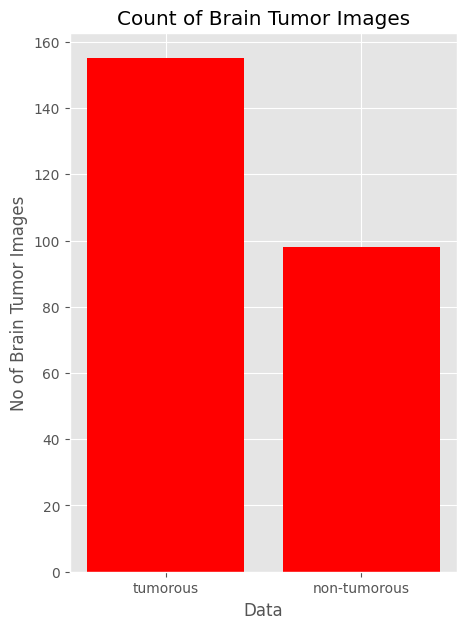

In [15]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

# DATA ARGUMENTATION

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [17]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [18]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    # Ensure the save directory exists
    os.makedirs(save_to_dir, exist_ok=True)
    data_gen = ImageDataGenerator(rotation_range=10, 
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        file_path = os.path.join(file_dir, filename)
        image = cv2.imread(file_path)
        if image is None:
            print(f"Warning: could not read {file_path}; skipping.")
            continue
        # If grayscale, convert to BGR so shapes are consistent
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + os.path.splitext(filename)[0]
        i = 0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, save_prefix=save_prefix, save_format="jpg"):
            i += 1
            # generate exactly n_generated_samples per input image
            if i >= n_generated_samples:
                break

In [19]:
import time
start_time = time.time()

# Use os.path.join for cross-platform-safe path construction
base_dir = r'C:\Users\SRIDHANVI\OneDrive\Documents\PROJECT'
yes_path = os.path.join(base_dir, 'yes')
no_path = os.path.join(base_dir, 'no')

augmented_data_path = os.path.join(base_dir, 'augmented_data')
# Ensure output folders exist
os.makedirs(os.path.join(augmented_data_path, 'yes'), exist_ok=True)
os.makedirs(os.path.join(augmented_data_path, 'no'), exist_ok=True)

augmented_data(file_dir=yes_path, n_generated_samples=6, save_to_dir=os.path.join(augmented_data_path, 'yes'))
augmented_data(file_dir=no_path, n_generated_samples=9, save_to_dir=os.path.join(augmented_data_path, 'no'))

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

0:2:10.236089706420898


In [20]:
def data_summary(main_path):
    yes_path = "augmented_data/yes/" 
    no_path = "augmented_data/no/"
    
    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))
    
    n = (n_pos + n_neg)
    
    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n
    
    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

In [21]:
data_summary(augmented_data_path)

Number of sample: 1811
930 Number of positive sample in percentage: 51.35284373274434%
881 Number of negative sample in percentage: 48.64715626725566%


In [22]:
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

930
881


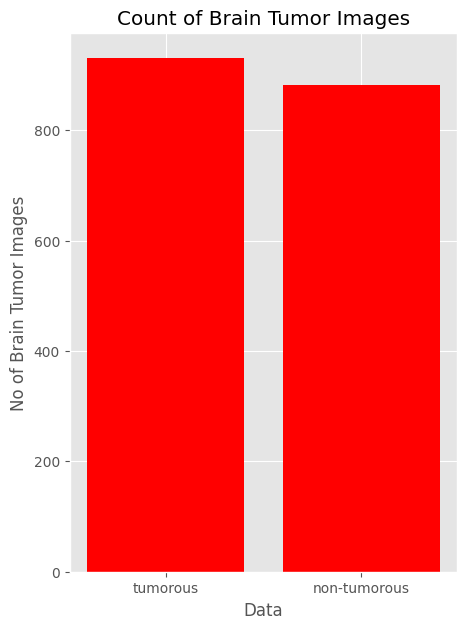

In [23]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

# DATA PREPROCESSING

In [24]:
pip install imutils

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [25]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    
    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)
    
    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)
    
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
    
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image

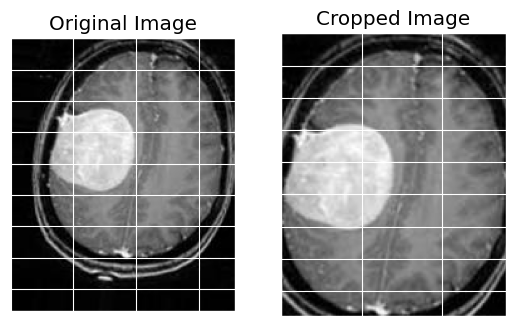

array([[[7, 7, 7],
        [7, 7, 7],
        [8, 8, 8],
        ...,
        [0, 0, 0],
        [2, 2, 2],
        [2, 2, 2]],

       [[6, 6, 6],
        [6, 6, 6],
        [9, 9, 9],
        ...,
        [0, 0, 0],
        [2, 2, 2],
        [2, 2, 2]],

       [[3, 3, 3],
        [3, 3, 3],
        [7, 7, 7],
        ...,
        [1, 1, 1],
        [2, 2, 2],
        [2, 2, 2]],

       ...,

       [[4, 4, 4],
        [6, 6, 6],
        [5, 5, 5],
        ...,
        [3, 3, 3],
        [2, 2, 2],
        [2, 2, 2]],

       [[4, 4, 4],
        [5, 5, 5],
        [1, 1, 1],
        ...,
        [4, 4, 4],
        [1, 1, 1],
        [2, 2, 2]],

       [[3, 3, 3],
        [5, 5, 5],
        [8, 8, 8],
        ...,
        [4, 4, 4],
        [1, 1, 1],
        [3, 3, 3]]], dtype=uint8)

In [27]:
img = cv2.imread('augmented_data/yes/aug_Y_1_0_1307.jpg')
crop_brain_tumor(img, True)

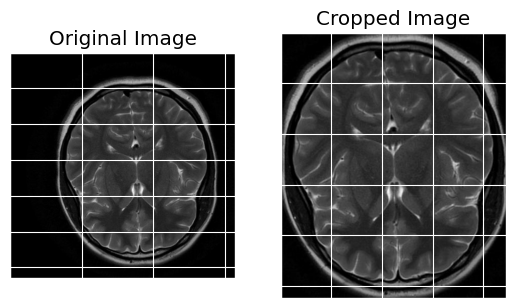

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [28]:
img = cv2.imread('augmented_data/no/aug_N_1_0_300.jpg')
crop_brain_tumor(img, True)

In [29]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

# IMAGE LOADING

In [30]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]
    
    image_width, image_height=image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)
    
    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y

In [31]:
augmented_path = 'augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmeneted_yes, augmeneted_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is : 1811
X SHAPE is : (1811, 240, 240, 3)
y SHAPE is : (1811,)


In [32]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

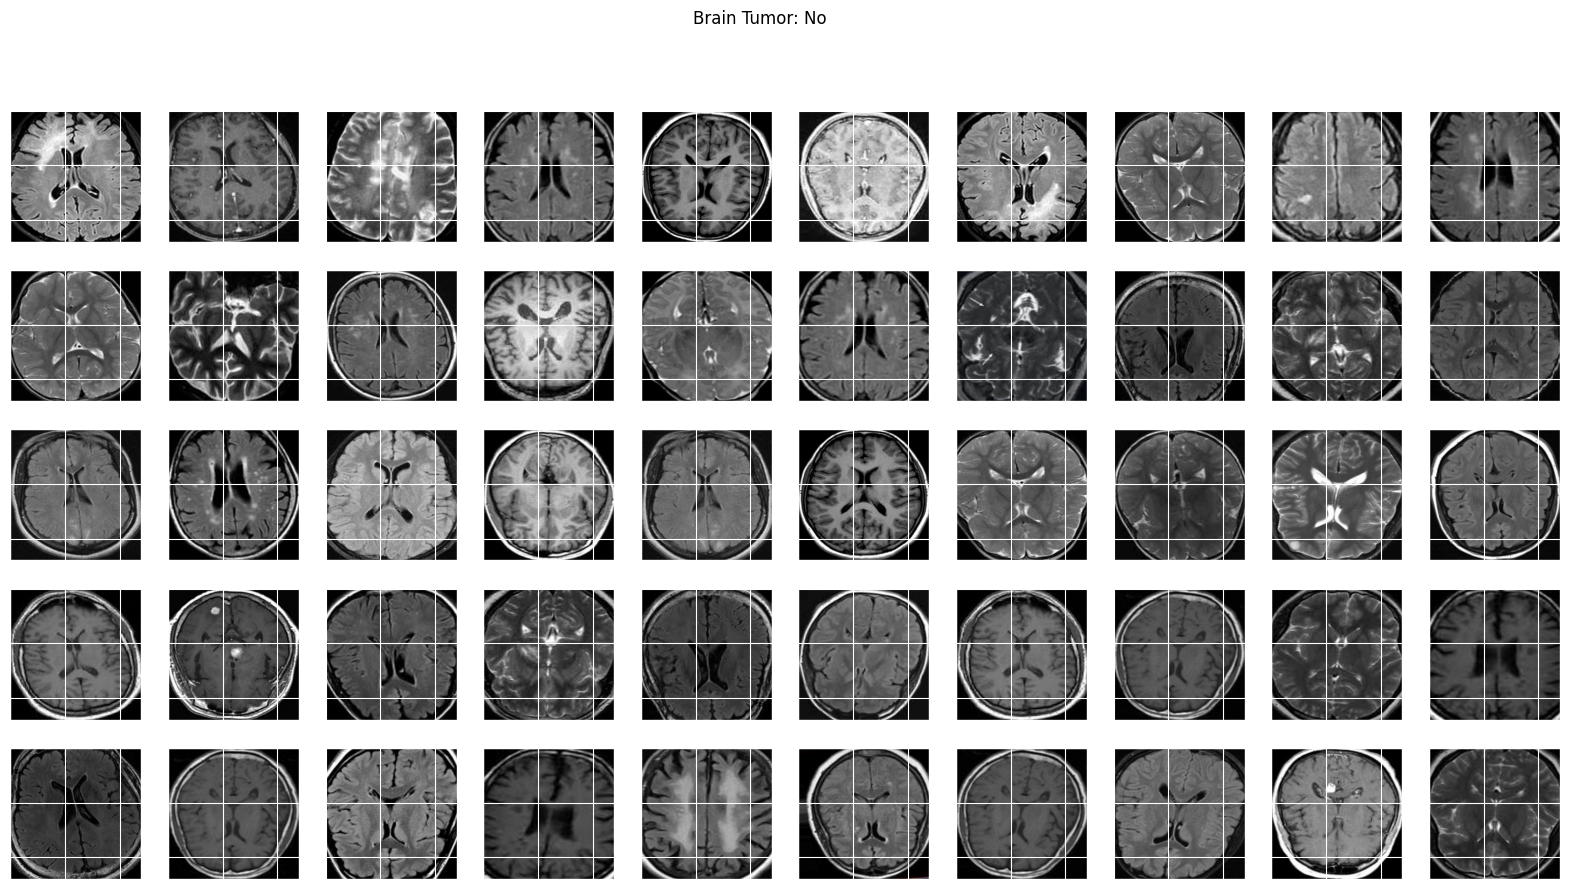

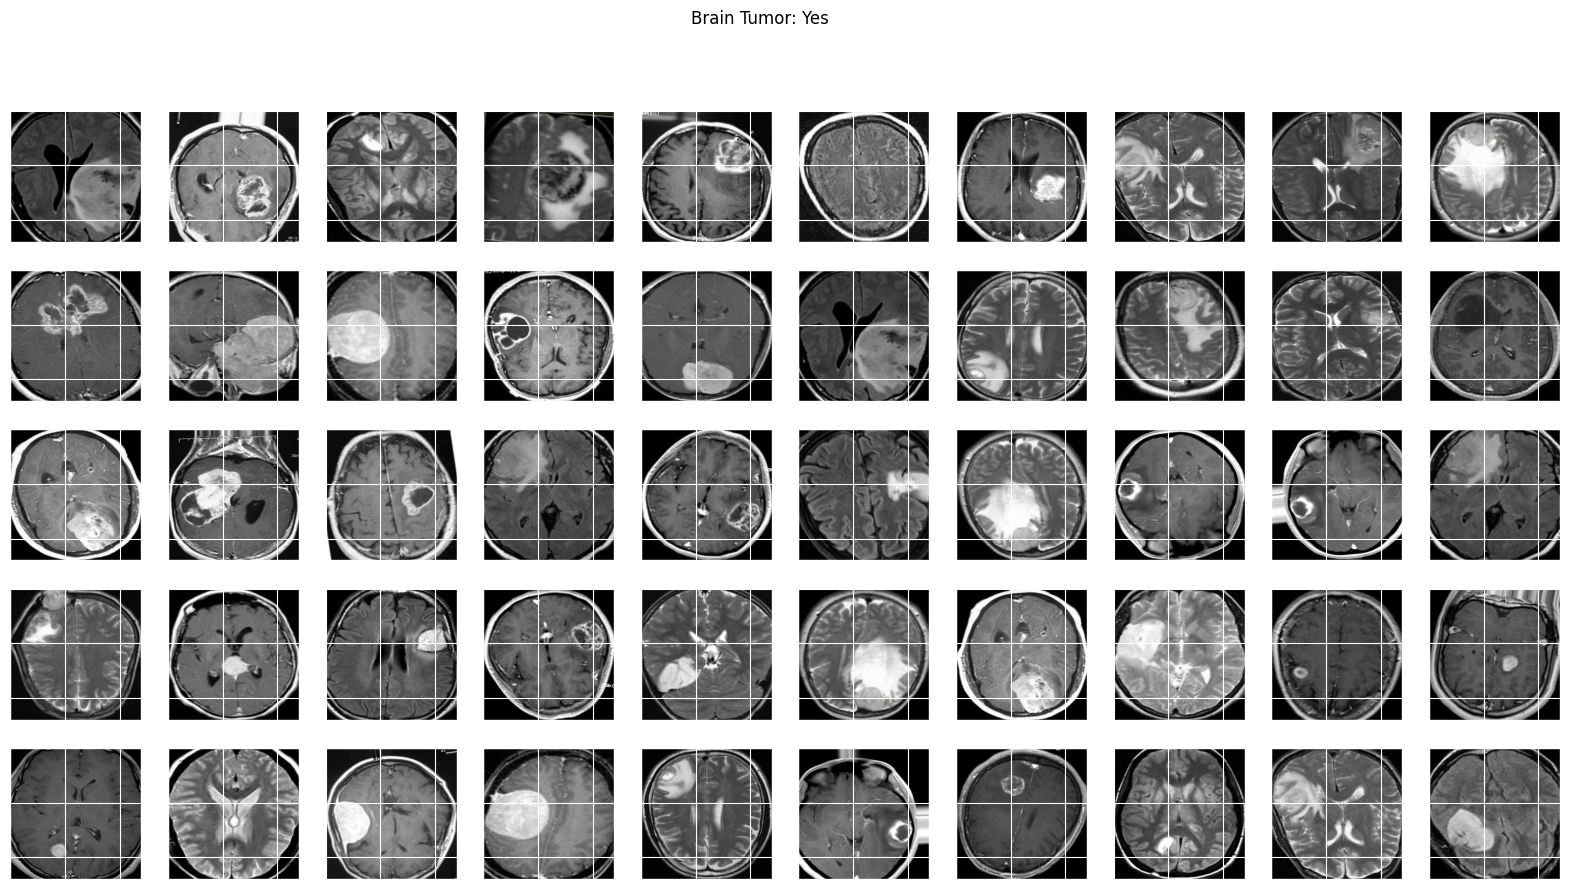

In [33]:
plot_sample_images(X,y)

# DATA SPLITTING

In [34]:
if not os.path.isdir('tumorous_and_nontumorous'):
    base_dir = 'tumorous_and_nontumorous'
    os.mkdir(base_dir)

if not os.path.isdir('tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)

if not os.path.isdir('tumorous_and_nontumorous/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)

if not os.path.isdir('tumorous_and_nontumorous/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
    os.mkdir(healthy_valid_dir)

In [35]:
original_dataset_tumorours = os.path.join('augmented_data','yes/')
original_dataset_nontumorours = os.path.join('augmented_data','no/')

In [36]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(0,759):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [37]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(0,759):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [38]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(759,922):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [39]:
# Safe copy for validation split: sort files, clamp indices and report status
src_dir = original_dataset_tumorours  # should be defined earlier
dst_dir = infected_valid_dir
# List only files and use a deterministic order
files = sorted([f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))])
start, end = 922, 1085
n = len(files)
# Clamp the requested range to available files
start = max(0, start)
end = min(n, end)
if start >= end:
    print(f'No files to copy for range {start}:{end} (available {n}).')
else:
    os.makedirs(dst_dir, exist_ok=True)
    copied = 0
    for fname in files[start:end]:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)
        if not os.path.exists(src):
            print('Missing source:', src)
            continue
        shutil.copy2(src, dst)
        copied += 1
    print(f'Copied {copied} files to {dst_dir} (range {start}:{end}).')

Copied 8 files to tumorous_and_nontumorous\valid\tumorous (range 922:930).


In [40]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0,686):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [41]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(686,833):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [42]:
# Safe copy for validation split (no class): sort files, clamp indices and report status
src_dir = original_dataset_nontumorours  # e.g. 'augmented_data/no/'
dst_dir = healthy_valid_dir
# Deterministic file list (files only)
files = sorted([f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))])
n = len(files)
print(f'Found {n} files in {src_dir}')
start, end = 833, 979  # Python slice: files[start:end], end exclusive
# Clamp indices to avoid IndexError
start = max(0, start)
end = min(n, end)
if start >= end:
    print(f'No files to copy for range {start}:{end} (available {n}).')
else:
    os.makedirs(dst_dir, exist_ok=True)
    copied = 0
    for fname in files[start:end]:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)
        if not os.path.exists(src):
            print('Missing source:', src)
            continue
        shutil.copy2(src, dst)
        copied += 1
    print(f'Copied {copied} files to {dst_dir} (range {start}:{end}).')

Found 881 files in augmented_data\no/
Copied 48 files to tumorous_and_nontumorous\valid\nontumorous (range 833:881).


# PSO IMPLEMENTATION

In [43]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import train_test_split
import copy

# Define the neural network architecture based on hyperparameters
class NeuralNetworkModel:
    def __init__(self, learning_rate=0.001, optimizer_type='adam', activation='relu', dropout_rate=0.5):
        self.learning_rate = learning_rate
        self.optimizer_type = optimizer_type
        self.activation = activation
        self.dropout_rate = dropout_rate
        
    def build_model(self, input_shape=(240, 240, 3)):
        model = Sequential([
            Conv2D(32, (3, 3), activation=self.activation, input_shape=input_shape),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation=self.activation),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation=self.activation),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(128, activation=self.activation),
            Dropout(self.dropout_rate),
            Dense(64, activation=self.activation),
            Dropout(self.dropout_rate),
            Dense(1, activation='sigmoid')
        ])
        
        # Select optimizer based on type
        if self.optimizer_type == 'adam':
            optimizer = Adam(learning_rate=self.learning_rate)
        elif self.optimizer_type == 'sgd':
            optimizer = SGD(learning_rate=self.learning_rate)
        else:  # rmsprop
            optimizer = RMSprop(learning_rate=self.learning_rate)
            
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        return model

print("Neural Network Model class defined successfully!")


Neural Network Model class defined successfully!


In [44]:
# Particle Swarm Optimization Implementation
class Particle:
    def __init__(self, particle_id):
        self.particle_id = particle_id
        
        # Define hyperparameter ranges
        # Learning rate: 0.0001 to 0.01
        # Optimizer: 0 (adam), 1 (sgd), 2 (rmsprop)
        # Activation: 0 (relu), 1 (tanh), 2 (sigmoid)
        # Dropout rate: 0.2 to 0.8
        
        self.position = np.array([
            np.random.uniform(0.0001, 0.01),  # learning_rate
            np.random.choice([0, 1, 2]),       # optimizer
            np.random.choice([0, 1, 2]),       # activation
            np.random.uniform(0.2, 0.8)        # dropout_rate
        ])
        
        self.velocity = np.random.uniform(-1, 1, 4)
        self.best_position = self.position.copy()
        self.best_fitness = -np.inf
        self.current_fitness = -np.inf
        
    def get_params(self):
        """Convert position to hyperparameters"""
        learning_rate = self.position[0]
        optimizer_types = ['adam', 'sgd', 'rmsprop']
        optimizer = optimizer_types[int(self.position[1]) % 3]
        activations = ['relu', 'tanh', 'sigmoid']
        activation = activations[int(self.position[2]) % 3]
        dropout_rate = np.clip(self.position[3], 0.2, 0.8)
        
        return {
            'learning_rate': learning_rate,
            'optimizer_type': optimizer,
            'activation': activation,
            'dropout_rate': dropout_rate
        }
    
    def __repr__(self):
        return f"Particle {self.particle_id}: {self.get_params()}"

print("Particle class defined successfully!")


Particle class defined successfully!


In [45]:
# PSO Algorithm Class
class ParticleSwarmOptimization:
    def __init__(self, num_particles=4, num_iterations=3, inertia=0.7, cognitive=1.5, social=1.5):
        self.num_particles = num_particles
        self.num_iterations = num_iterations
        self.inertia = inertia
        self.cognitive = cognitive
        self.social = social
        self.particles = [Particle(i) for i in range(num_particles)]
        self.global_best_position = None
        self.global_best_fitness = -np.inf
        self.fitness_history = []
        
    def evaluate_particle(self, particle, X_train, X_val, y_train, y_val):
        """Train model and return validation accuracy as fitness"""
        params = particle.get_params()
        
        try:
            # Build and train model
            model = NeuralNetworkModel(**params).build_model()
            
            # Train for limited epochs to speed up evaluation
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=5,
                batch_size=32,
                verbose=0
            )
            
            # Get validation accuracy
            val_accuracy = max(history.history['val_accuracy'])
            return val_accuracy
            
        except Exception as e:
            print(f"Error training model: {e}")
            return 0.0
    
    def update_particle(self, particle, best_position):
        """Update particle's velocity and position"""
        # Update velocity
        cognitive_component = self.cognitive * np.random.random(4) * (particle.best_position - particle.position)
        social_component = self.social * np.random.random(4) * (best_position - particle.position)
        particle.velocity = (self.inertia * particle.velocity + cognitive_component + social_component)
        
        # Update position with constraints
        particle.position[0] = np.clip(particle.position[0] + particle.velocity[0], 0.0001, 0.01)  # learning_rate
        particle.position[1] = (particle.position[1] + particle.velocity[1]) % 3  # optimizer (keep as 0,1,2)
        particle.position[2] = (particle.position[2] + particle.velocity[2]) % 3  # activation (keep as 0,1,2)
        particle.position[3] = np.clip(particle.position[3] + particle.velocity[3], 0.2, 0.8)  # dropout_rate
        
    def optimize(self, X_train, X_val, y_train, y_val):
        """Run PSO optimization"""
        print(f"Starting PSO with {self.num_particles} particles for {self.num_iterations} iterations...")
        
        # Evaluate initial population
        for particle in self.particles:
            fitness = self.evaluate_particle(particle, X_train, X_val, y_train, y_val)
            particle.current_fitness = fitness
            particle.best_fitness = fitness
            particle.best_position = particle.position.copy()
            
            print(f"{particle} -> Fitness: {fitness:.4f}")
            
            # Update global best
            if fitness > self.global_best_fitness:
                self.global_best_fitness = fitness
                self.global_best_position = particle.position.copy()
        
        # PSO iterations
        for iteration in range(self.num_iterations):
            print(f"\n--- Iteration {iteration + 1}/{self.num_iterations} ---")
            
            for particle in self.particles:
                # Update particle
                self.update_particle(particle, self.global_best_position)
                
                # Evaluate new position
                fitness = self.evaluate_particle(particle, X_train, X_val, y_train, y_val)
                particle.current_fitness = fitness
                
                print(f"{particle} -> Fitness: {fitness:.4f}")
                
                # Update personal best
                if fitness > particle.best_fitness:
                    particle.best_fitness = fitness
                    particle.best_position = particle.position.copy()
                
                # Update global best
                if fitness > self.global_best_fitness:
                    self.global_best_fitness = fitness
                    self.global_best_position = particle.position.copy()
            
            self.fitness_history.append(self.global_best_fitness)
            print(f"Global Best Fitness: {self.global_best_fitness:.4f}")
        
        return self.global_best_position, self.global_best_fitness

print("PSO class defined successfully!")


PSO class defined successfully!


In [46]:
# Prepare training and validation data
# Split the augmented data into train and validation sets
X_train_full, X_temp, y_train_full, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train_full.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")

# Use a smaller subset for faster PSO iterations (optional, for speed)
X_train_pso = X_train_full[:500]  # Use 500 samples for PSO
y_train_pso = y_train_full[:500]

print(f"PSO training set size: {X_train_pso.shape}")


Training set size: (1267, 240, 240, 3)
Validation set size: (272, 240, 240, 3)
Test set size: (272, 240, 240, 3)
PSO training set size: (500, 240, 240, 3)


In [47]:
# Run PSO Optimization
print("="*80)
print("PARTICLE SWARM OPTIMIZATION - Brain Tumor Detection")
print("="*80)

# Initialize PSO with 4 particles
pso = ParticleSwarmOptimization(
    num_particles=4,
    num_iterations=3,
    inertia=0.7,
    cognitive=1.5,
    social=1.5
)

# Run optimization
best_position, best_fitness = pso.optimize(X_train_pso, X_val, y_train_pso, y_val)

print("\n" + "="*80)
print("OPTIMIZATION COMPLETE")
print("="*80)
print(f"\nGlobal Best Fitness (Validation Accuracy): {best_fitness:.4f}")


PARTICLE SWARM OPTIMIZATION - Brain Tumor Detection
Starting PSO with 4 particles for 3 iterations...
Particle 0: {'learning_rate': 0.006364959381064105, 'optimizer_type': 'rmsprop', 'activation': 'sigmoid', 'dropout_rate': 0.7660301207703846} -> Fitness: 0.5037
Particle 1: {'learning_rate': 0.0014723663954257485, 'optimizer_type': 'sgd', 'activation': 'tanh', 'dropout_rate': 0.7572752989022669} -> Fitness: 0.5993
Particle 2: {'learning_rate': 0.0003721696983738858, 'optimizer_type': 'adam', 'activation': 'tanh', 'dropout_rate': 0.28450811609834825} -> Fitness: 0.5037
Particle 3: {'learning_rate': 0.0017478172478250695, 'optimizer_type': 'adam', 'activation': 'relu', 'dropout_rate': 0.6710199781637358} -> Fitness: 0.5037

--- Iteration 1/3 ---
Particle 0: {'learning_rate': 0.01, 'optimizer_type': 'rmsprop', 'activation': 'relu', 'dropout_rate': 0.6096335002040665} -> Fitness: 0.5037
Particle 1: {'learning_rate': 0.01, 'optimizer_type': 'adam', 'activation': 'relu', 'dropout_rate': 0.36

KeyboardInterrupt: 

In [ ]:
# Extract and Display Best Particle's Parameters
best_particle = Particle(0)
best_particle.position = best_position

best_params = best_particle.get_params()

print("\n" + "="*80)
print("BEST PARTICLE'S PARAMETER SET")
print("="*80)
print(f"\nBest Parameters Found:")
print(f"  • Learning Rate: {best_params['learning_rate']:.6f}")
print(f"  • Optimizer: {best_params['optimizer_type']}")
print(f"  • Activation Function: {best_params['activation']}")
print(f"  • Dropout Rate: {best_params['dropout_rate']:.4f}")
print(f"\nBest Validation Accuracy Achieved: {best_fitness:.4f} ({best_fitness*100:.2f}%)")
print("="*80)

# Create a summary dataframe
summary_data = {
    'Parameter': ['Learning Rate', 'Optimizer', 'Activation Function', 'Dropout Rate', 'Best Accuracy'],
    'Value': [
        f"{best_params['learning_rate']:.6f}",
        best_params['optimizer_type'],
        best_params['activation'],
        f"{best_params['dropout_rate']:.4f}",
        f"{best_fitness:.4f}"
    ]
}

best_params_df = pd.DataFrame(summary_data)
print("\nBest Parameters Summary:")
print(best_params_df.to_string(index=False))


In [ ]:
# Visualize PSO Fitness History
plt.figure(figsize=(10, 6))
plt.plot(pso.fitness_history, marker='o', linewidth=2, markersize=8, color='blue')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Best Fitness (Validation Accuracy)', fontsize=12)
plt.title('PSO Convergence - Fitness History', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])
for i, fitness in enumerate(pso.fitness_history):
    plt.text(i, fitness + 0.02, f'{fitness:.4f}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# Display all particles' final parameters
print("\n" + "="*80)
print("ALL PARTICLES' FINAL PARAMETERS")
print("="*80)
for i, particle in enumerate(pso.particles):
    params = particle.get_params()
    print(f"\nParticle {i + 1}:")
    print(f"  • Learning Rate: {params['learning_rate']:.6f}")
    print(f"  • Optimizer: {params['optimizer_type']}")
    print(f"  • Activation Function: {params['activation']}")
    print(f"  • Dropout Rate: {params['dropout_rate']:.4f}")
    print(f"  • Best Fitness: {particle.best_fitness:.4f}")
